### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.functions import hour, dayofweek, month
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler, Bucketizer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize Spark session
spark = SparkSession.builder.appName("NYC_Taxi_Data_Analysis").getOrCreate()


### Data Preprocessing

In [ ]:
# Load the CSV data
file_path = "yellow_tripdata_2015-01.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

df.printSchema()
df.show(5)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

+--------+--------------------+---------------------+---------------+-------------+------------------+---------------

In [ ]:
missing_df = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
missing_df.show()

df = df.dropna(subset=["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"])

df = df.filter((df["trip_distance"] > 0) & (df["fare_amount"] > 0))

+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|pickup_longitude|pickup_latitude|RateCodeID|store_and_fwd_flag|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------------+---------------+----------+------------------+-----------------+----------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       0|                   0|                    0|              0|            0|               0|              0|         0|                 0|              

In [ ]:
df = df.withColumn("pickup_datetime", to_timestamp("tpep_pickup_datetime")) \
       .withColumn("dropoff_datetime", to_timestamp("tpep_dropoff_datetime"))

df = df.withColumn("trip_duration", 
                   (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60)

df = df.withColumn("hour_of_day", hour("pickup_datetime"))

### Data Analysis and Visualization

In [6]:
# Summary statistics
df.select("trip_distance", "fare_amount", "trip_duration").describe().show()

+-------+------------------+------------------+-------------------+
|summary|     trip_distance|       fare_amount|      trip_duration|
+-------+------------------+------------------+-------------------+
|  count|          12664586|          12664586|           12664586|
|   mean|13.547240121390352|11.869102171993553| 14.240865236336877|
| stddev|  9876.84145479976| 9.860660937794515|  651.0171618377975|
|    min|              0.01|              0.01|-1211.0166666666667|
|    max|      1.54200045E7|            4008.0|  548555.6333333333|
+-------+------------------+------------------+-------------------+



In [7]:
df.describe().show()

+-------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+------------------+-------------------+---------------------+-----------------+-------------------+------------------+
|summary|           VendorID|  passenger_count|     trip_distance|   pickup_longitude|   pickup_latitude|        RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|       payment_type|       fare_amount|             extra|            mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|     total_amount|      trip_duration|       hour_of_day|
+-------+-------------------+-----------------+------------------+-------------------+------------------+------------------+------------------+------------------+------------------+-------------------+------------------+------------------+-----

In [8]:
sample_df = df.select("trip_distance", "fare_amount", "passenger_count").sample(fraction=0.1).toPandas()

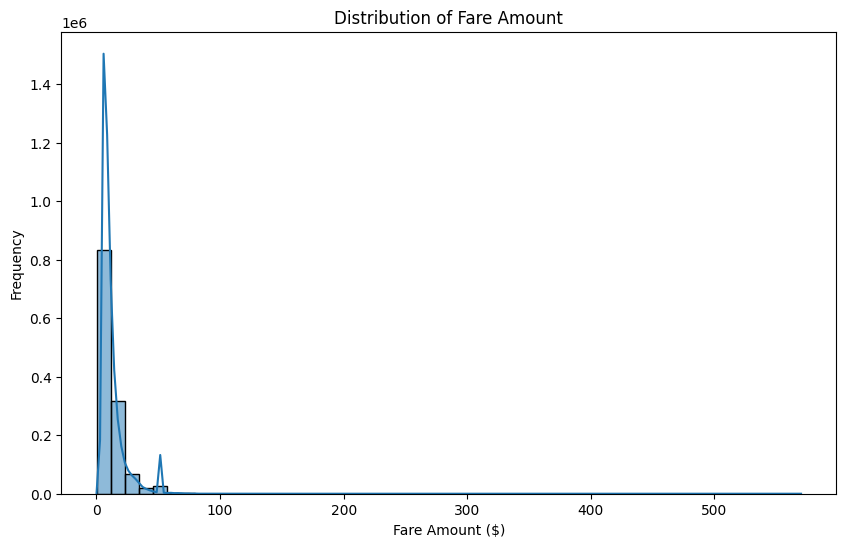

In [ ]:
# Plot distribution of fare amount
plt.figure(figsize=(10, 6))
sns.histplot(sample_df["fare_amount"], bins=50, kde=True) 
plt.title("Distribution of Fare Amount")
plt.xlabel("Fare Amount ($)")
plt.ylabel("Frequency")
plt.show()

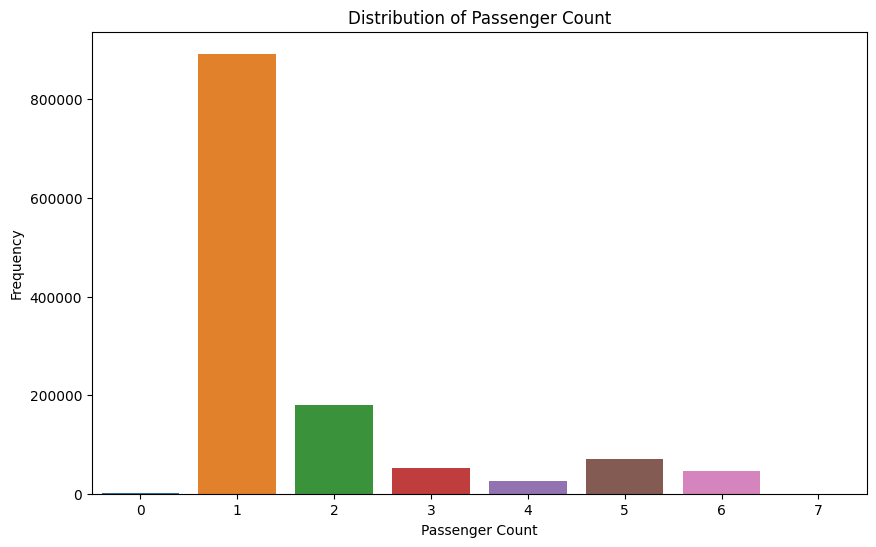

In [10]:
# Plot distribution of passenger count
plt.figure(figsize=(10, 6))
sns.countplot(x="passenger_count", data=sample_df)
plt.title("Distribution of Passenger Count")
plt.xlabel("Passenger Count")
plt.ylabel("Frequency")
plt.show()

In [11]:
# Average fare and trip distance by hour of day
hourly_trends = df.groupBy("hour_of_day").agg(
    avg("fare_amount").alias("avg_fare"), 
    avg("trip_distance").alias("avg_distance")
).orderBy("hour_of_day")
hourly_trends.show()

+-----------+------------------+------------------+
|hour_of_day|          avg_fare|      avg_distance|
+-----------+------------------+------------------+
|          0|12.659185781783302|3.2726353779004937|
|          1| 12.50438870271503| 9.059829433147799|
|          2|12.456261591387834| 3.244231002558491|
|          3| 12.95453643380797|3.4966888420665967|
|          4|14.540374247672032| 4.084434689416307|
|          5|15.602317869690188| 4.597396997764295|
|          6|12.831358652459036| 4.088956876127626|
|          7|11.744691000821009| 2.849794728850513|
|          8|11.508287898180402|2.4821231036365385|
|          9|11.449497819167766| 2.599484609357124|
|         10|11.399575652913219| 32.50827119034343|
|         11|11.345536433084106|2.4777224518417094|
|         12|11.322779700169965|2.5723072019490014|
|         13|11.628492619009203| 5.081910557523618|
|         14|12.136055956017127| 2.728857299938914|
|         15| 12.22654262757389| 47.40763822862494|
|         16

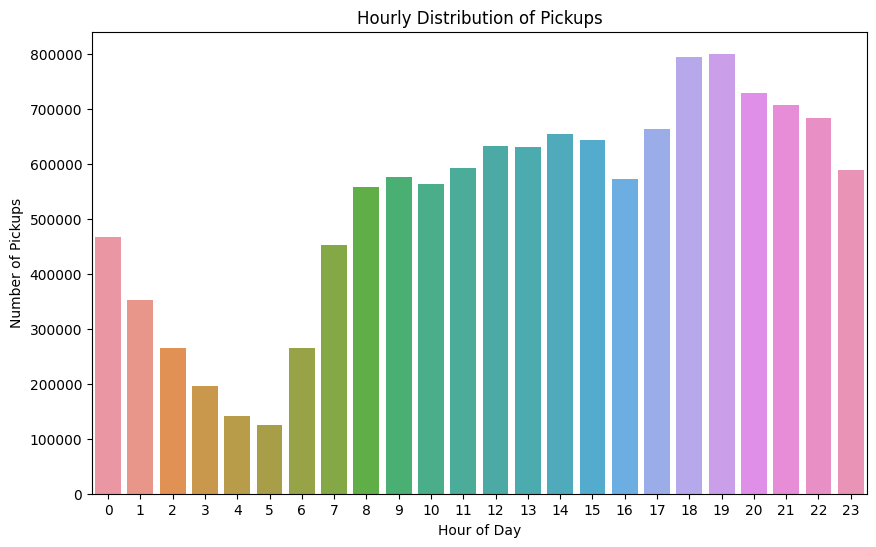

In [ ]:
# Pickup and Dropoff Times Analysis
df_time = df.withColumn("pickup_hour", hour("pickup_datetime")) \
            .withColumn("pickup_day", dayofweek("pickup_datetime"))

# Hourly pickup analysis
hourly_pickups = df_time.groupBy("pickup_hour").count().orderBy("pickup_hour")
hourly_pickups_pd = hourly_pickups.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="pickup_hour", y="count", data=hourly_pickups_pd)
plt.title("Hourly Distribution of Pickups")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Pickups")
plt.show()

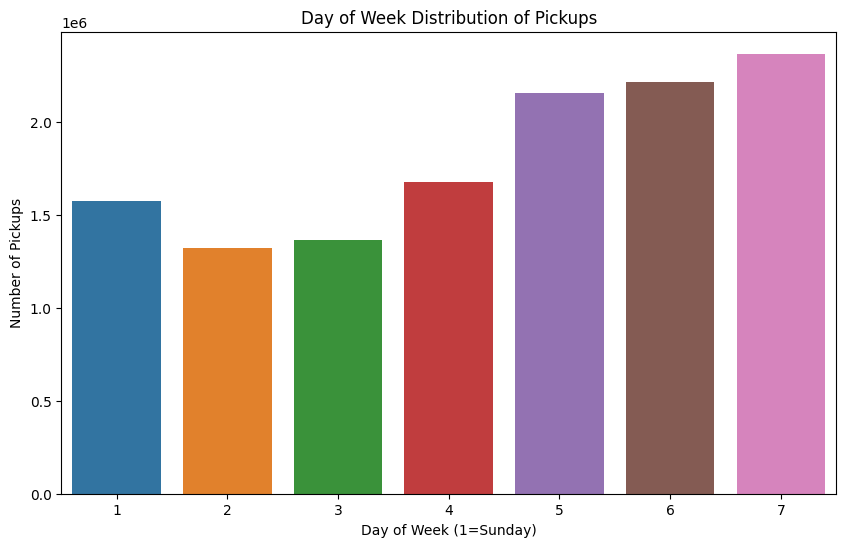

In [13]:
# Day of week pickup analysis
weekday_pickups = df_time.groupBy("pickup_day").count().orderBy("pickup_day")
weekday_pickups_pd = weekday_pickups.toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(x="pickup_day", y="count", data=weekday_pickups_pd)
plt.title("Day of Week Distribution of Pickups")
plt.xlabel("Day of Week (1=Sunday)")
plt.ylabel("Number of Pickups")
plt.show()


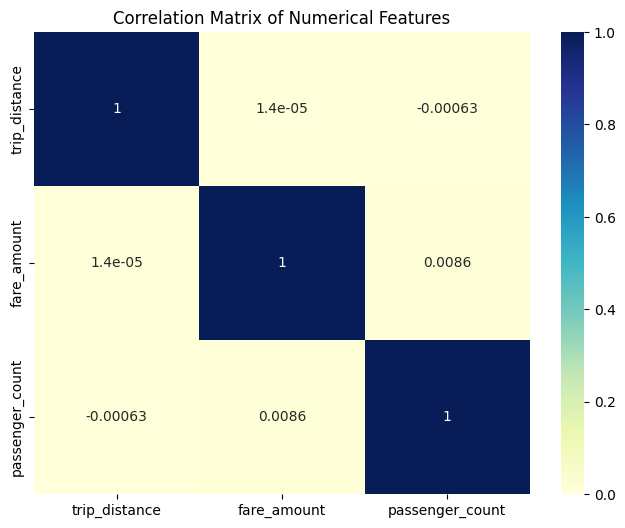

In [ ]:
# Correlation Matrix
numerical_df = sample_df[["trip_distance", "fare_amount", "passenger_count"]]
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="YlGnBu")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

Simple Regression

In [ ]:
df = df.withColumn("hour_of_day", hour("pickup_datetime"))

# Select features and target
feature_columns = ["trip_distance", "trip_duration", "hour_of_day"]
df_model = df.select("fare_amount", *feature_columns)

df_model = df_model.na.drop()


In [17]:
# Assemble features into a single vector column
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_model = assembler.transform(df_model)

# Select only the features and label columns for modeling
df_model = df_model.select("features", "fare_amount")


In [18]:
train_data, test_data = df_model.randomSplit([0.8, 0.2], seed=42)


In [19]:
# Initialize the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="fare_amount")

# Train the model
lr_model = lr.fit(train_data)


In [ ]:
# Predict on the test data
test_results = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

rmse = evaluator.evaluate(test_results)
print("Root Mean Squared Error (RMSE) on test data =", rmse)

r2_evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
r2 = r2_evaluator.evaluate(test_results)
print("R^2 on test data =", r2)


Root Mean Squared Error (RMSE) on test data = 9.790008326035185
R^2 on test data = 0.0007034845423236069


Classification Model

In [21]:
# Add columns for trip distance, duration, and time of day
df_classification = df.withColumn("trip_duration", 
                                  (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60) \
                      .withColumn("hour_of_day", hour("pickup_datetime"))

# Ensure the necessary columns are present
df_classification = df_classification.select("fare_amount", "trip_distance", "trip_duration", "hour_of_day").na.drop()

# Define fare amount ranges and bucketize
splits = [-float("inf"), 10, 20, 50, float("inf")]
bucketizer = Bucketizer(splits=splits, inputCol="fare_amount", outputCol="fare_range")
df_classification = bucketizer.transform(df_classification)

# Assemble the features into a vector column
feature_columns = ["trip_distance", "trip_duration", "hour_of_day"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_classification = assembler.transform(df_classification).select("features", "fare_range")

# Split into training and testing sets
train_data, test_data = df_classification.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(featuresCol="features", labelCol="fare_range", numTrees=50)
rf_model = rf_classifier.fit(train_data)

# Predictions on test data
predictions = rf_model.transform(test_data)

# Evaluate the classification model
evaluator = MulticlassClassificationEvaluator(labelCol="fare_range", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy of classification model =", accuracy)


Accuracy of classification model = 0.9588334505122958


In [ ]:
df.write.mode("overwrite").parquet("file:/d:/Misc/SIT Assgnmnt/7th Sem/PROJECTS/BDA/processed_yellow_tripdata_2015-01.parquet")